## Adversarial Debiasing

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-preparation)
3. [Classifier network](#3.-Classifier-network)
	*  [Model Fairness for Classifier Network](#Model-Fairness-for-Classifier)
4. [Mitigate the model bias with Adversarial networks](#4.-Mitigate-the-model-bias-with-Adversarial-networks)
	* [Model Fairness for Adversarial networks](#Model-Fairness-for-Adversarial-networks)
5. [Summary](#5.-Summary)
6. [References](#References)

## 1. Introduction

Welcome !

We hope you have had a chance to go through the [previous sony fairness tutorials](https://github.com/sony/nnabla-examples/blob/master/interactive-demos/gender_bias_mitigation_german_cc.ipynb). In that tutorial, we had touched upon a pre-processing technique for bias mitigation ([Rewighing algroithm](https://link.springer.com/content/pdf/10.1007%2Fs10115-011-0463-8.pdf)) and also showed how to compute model fairness using different fairness criteria.

In this tutorial, we give an overview of an in-processing technique for bias mitigation in predictive models. In-processing techniques involve modification of learning algorithms to address discrimination during the model training phase. [Classification with Fairness Constraints](https://arxiv.org/abs/1806.06055), [Prejudice Remover Regularizer](https://link.springer.com/content/pdf/10.1007%2F978-3-642-33486-3_3.pdf) and [Adversarial Debiasing](https://arxiv.org/pdf/1801.07593.pdf) are among the different in-processing bias mitigation techniques currently proposed from academic literature. In this tutorial we will see how to mitigate the bias in predictive model using `Adversarial Debiasing` technique.

Before we go into detailed explanation, here is a sneak peek into the steps involved in the process:


### Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click **Connect** on the top right-hand side of the screen before you start.

In [1]:
# Preparation
# May show warnings for newly imported packages if run in Colab default python environment.
# Please click the `RESTART RUNTIME` to run the following script correctly.
# The error message of conflicts is acceptable.
# !pip install nnabla-ext-cuda116
!pip install nnabla-ext-cuda120
# for cpu set context as "!pip install nnabla"
!git clone https://github.com/sony/nnabla-examples.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 527.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
ERROR: pip's dependency resolver does not current

Cloning into 'nnabla-examples'...
remote: Enumerating objects: 9643, done.
remote: Counting objects: 100% (2201/2201), done.
remote: Compressing objects: 100% (880/880), done.
remote: Total 9643 (delta 1280), reused 2117 (delta 1261), pack-reused 7442
Receiving objects: 100% (9643/9643), 298.96 MiB | 35.41 MiB/s, done.
Resolving deltas: 100% (5244/5244), done.
Updating files: 100% (1711/1711), done.


In [1]:
%cd nnabla-examples/responsible_ai/adversarial_debiasing

/content/nnabla-examples/responsible_ai/adversarial_debiasing


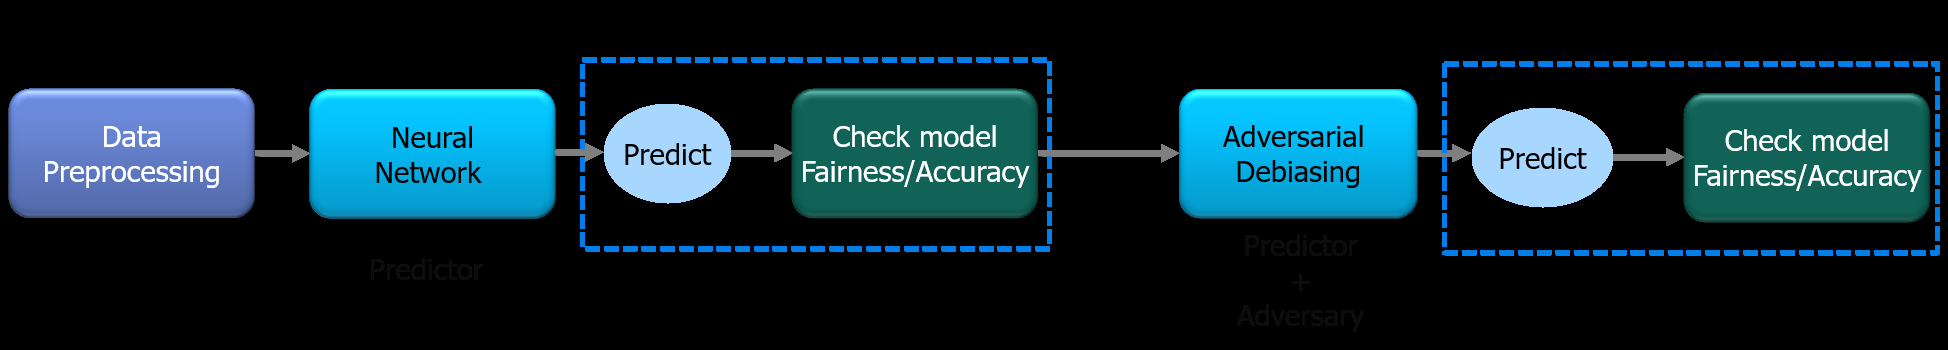

In [2]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/adversarial_debiasing_workflow.png')
cv2_imshow(img)

As illustrated in the picture, we will train a model to make income level predictions, analyse model fairness and then show how adversarial training can be employed to make the model fair if fairness metric is not upto the mark.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import nnabla as nn
from nnabla.logger import logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.utils.data_iterator import data_iterator
from nnabla.utils.data_source import DataSource
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utils import *

## 2. Data preparation

Before training a model, we need to parse [adult](https://archive.ics.uci.edu/ml/datasets/Adult) dataset into three categories i.e: features, targets, and sensitive attributes. The set of features contains the input attributes, targets contain the binary class labels (income range). Finally, sensitive attributes contain the attributes for which we want the prediction to be fair(race, sex, etc.).

Note: sensitive attributes race and sex are not part of the features.

Next, we split the data into train and test sets, and scale the features using standard scaling.

In [4]:
X, y, Z = load_adult_data()
Z = Z.drop(['sex'], axis = 1)

# split into train/test set
(X_train, X_test, y_train, y_test,
 Z_train, Z_test) = train_test_split(X, y, Z, test_size=0.5,stratify=y, random_state=7)

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)

features : 28750 samples, 88 attributes

targets : 28750 samples

sensitives attributes : 28750 samples, 2 attributes

NNabla provides various utilities for using data for training. Here, we will use NNabla DataSource and data_iterator.

In [5]:
class dataset(DataSource):
    def __init__(self,features, labels, senstive_attribute,shuffle=False):
        super(dataset, self).__init__(shuffle=shuffle)
        self.x = features
        self.y = labels.reshape(-1,1)
        self.z = senstive_attribute
        self._size = self.y.size
        self._variables = ('x', 'y','z')

    def _get_data(self,idx):
        return self.x[idx],self.y[idx],self.z[idx]
trainset = dataset(X_train,y_train.to_numpy(),Z_train.to_numpy(),shuffle=True)
testset = dataset(X_test,y_test.to_numpy(),Z_test.to_numpy())

batachsize = 32
trainloader = data_iterator(trainset,batch_size=batachsize)
test_batchsize = X_test.shape[0]
testloader = data_iterator(testset,batch_size=test_batchsize)

## 3. Classifier network

Let’s start with importing basic modules to switch between CPU and GPU.

In [6]:
from nnabla.ext_utils import get_extension_context
context = "cudnn" # for cpu set context as 'cpu'
device_id = 0
ctx = get_extension_context(context, device_id=device_id)
nn.set_default_context(ctx)

Now we are going to create input variables for the network.

In [7]:
n_feature = nn.Variable((batachsize,88))
n_label = nn.Variable((batachsize,1))
n_senstive = nn.Variable((batachsize,1))

test_feature = nn.Variable((test_batchsize,88))
test_label = nn.Variable((test_batchsize,1))
test_senstive = nn.Variable((test_batchsize,1))

Let us create a simple computation graph in NNabla to train our basic income level predictor. Our network consists of three sequential hidden layers with ReLu activation and dropout for regularization.

In [8]:
def Classifier(features_n, n_hidden=32, p_dropout=0.2,train=True):
    with nn.parameter_scope('classifier'):
        l1 = PF.affine(features_n, n_hidden, name='l1')
        l1 = F.relu(l1)
        if (train):
            l1 = F.dropout(l1,p_dropout)
        l2 = PF.affine(l1, n_hidden, name='l2')
        l2 = F.relu(l2)
        if (train):
            l2 = F.dropout(l2,p_dropout)
        l3 = PF.affine(l2, n_hidden, name='l3')
        l3 = F.relu(l3)
        if (train):
            l3 = F.dropout(l3,p_dropout)
        l4 = PF.affine(l3, 1, name='l4')
    return l4

The parameters are created and initialized randomly at function call and registered by a name `classifier` using parameter_scope context.

We have defined the classifier network and it returns the output of the last affine layer.

Let us create training graph first.

In [9]:
clf = Classifier(n_feature)
clf.persistent = True

Creating the validation graph is almost the same. You simply need to change `train` flag to `False`.

In [10]:
v_clf = Classifier(test_feature,train=False)

Let's choose sigmoid cross-entropy as the loss function and Adam optimizer as our solver.

In [11]:
loss = F.mean(F.sigmoid_cross_entropy(clf, n_label))

loss.persistent = True

learning_rate = 1e-03

clf_solver = S.Adam(learning_rate)

with nn.parameter_scope("classifier"):
    clf_solver.set_parameters(nn.get_parameters())

We shall train the classifier now. For each epoch, we'll iterate over the batches returned by our `data_iterator`.

In [12]:
max_iter = 449
for epoch in range(10):
    for i in range(max_iter):
        n_feature.d, n_label.d, _ = trainloader.next()
        clf_solver.zero_grad()
        loss.forward(clear_no_need_grad=True)
        loss.backward(clear_buffer=True)
        clf_solver.update()

The above for loop does the following for each batch:
1. Retrieve new batch of data.
2. Initialize gradients to zero.
3. Execute the computation of the graph by calling the loss.forward(). Compute the loss.
4. Execute backprop by calling loss.backward(), to compute gradients.
5. Update the classfier weights (clf_solver.update()).

### Model Fairness for Classifier
Let's start our investigation classifier model fairness by analysing the predictions it made on the test set. In the previous tutorial (three metric tutorial link goes here), we've shown how to measure model fairness using different fairness criteria (Demographic parity, Equal opportunity & Equalized odds).

In [13]:
test_feature.d, test_label.d,test_senstive.d = testloader.next()
v_clf_out = F.sigmoid(v_clf)
v_clf_out.forward(clear_buffer=True)
y_pre_clf = v_clf_out.d.ravel()

In [14]:
# model validation & fairness
preds = np.where(y_pre_clf > 0.5, 1, 0)
DPD,EOD,AAOD = get_fairness(y_test, Z_test['race'] == 1, preds)
clf_accuracy = metrics.accuracy_score(y_test, preds) * 100

In this tutorial, we adopt/compute one more well-known fairness metric - `p% rule` (Zafar et al. show in their paper ["Fairness Constraints: Mechanisms for Fair Classification"](https://arxiv.org/pdf/1507.05259.pdf)).

The rule states that the ratio between the probability of a positive outcome given the sensitive attribute being true and the same probability given the sensitive attribute being false is no less than p:100. So, when a classifier is completely fair it will satisfy a 100%-rule. In contrast, when it is completely unfair it satisfies a %0-rule.

A classifier that makes a binary class prediction $\hat{y} \in \left\{0,1 \right\} $ given a binary sensitive attribute $ z\in \left\{0,1 \right\}$, one may write `p%-rule` as :

$$\min\left(\frac{P(\hat{y}=1|z=1)}{P(\hat{y}=1|z=0)}, \frac{P(\hat{y}=1|z=0)}{P(\hat{y}=1|z=1)}\right)\geq\frac{p}{100}$$

In [15]:
race_p_rule = get_p_rule(y_pre_clf, Z_test['race'])

Let's plot model fairness from above data.

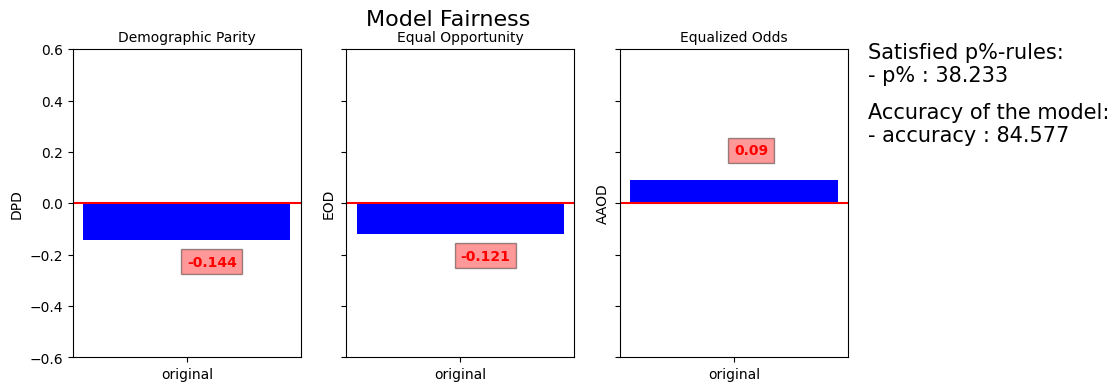

In [16]:
plot_fairness_multi(DPD,EOD,AAOD,race_p_rule,clf_accuracy)

As seen in above plots, predictions are definitely not fair when considered in the context of race as a sensitive attribute.

How to mitigate this bias?
#### Mitigate the bias
In General, we can follow two approaches
1. Remove the bias from the dataset (pre-processing bias mitigation technique) and train the model, as illustrated in the gender bias mitigation tutorial.
2. Constrain the model so that it is forced into making fairer predictions.

In the next section, we will show you how the second approach helps in making fair decisions using adversarial network.

## 4. Mitigate the model bias with Adversarial networks

### Adversarial Debiasing :

[Adversarial debiasing](https://arxiv.org/pdf/1801.07593.pdf) procedure takes inspiration from [GANs](https://arxiv.org/abs/1406.2661) (Goodfellow et al. 2014) for training a fair classifier. In GANs they introduce a system of two neural networks in which the two neural networks compete with each other to become more accurate in their predictions. Likewise, in adversarial debiasing, we build two models:
1. First model is a classifier which predicts target variable based on input features (training data).
2. Second model is an adversary and it tries to predict, the sensitive attribute based on the predictions of the classifier model.

Before diving into the detailed explanation of the adversary training procedure, let's define the computation graph of the adversary network.

Similar to the Classifier, our adversary consists of three layers. However, the input comes from a single class (the predicted income class) and the output consists of one sensitive class(race).

In [17]:
def Adversary(clf_out,n_hidden=32):
    with nn.parameter_scope("adversary"):
        Al1 = PF.affine(clf_out, n_hidden, name='Al1')
        Al1 = F.relu(Al1)
        Al2 = PF.affine(Al1, n_hidden, name='Al2')
        Al2 = F.relu(Al2)
        Al3 = PF.affine(Al2, n_hidden, name='Al3')
        Al3 = F.relu(Al3)
        Al4 = PF.affine(Al3,1, name='Al4')
        return Al4

Let's intiailize the adversary network

In [18]:
adv = Adversary(clf)

For our final solution, there will be a trade-off between classifier performance and fairness for our sensitive attributes.

We will tweak the adversarial loss to incorporate that trade-off: the lambda parameter weighs the adversarial loss of each class.

In [19]:
lamdas = 130
adv_loss = F.mean(F.mul_scalar(F.sigmoid_cross_entropy(adv, n_senstive), lamdas))
adv_solver = S.Adam(learning_rate)
with nn.parameter_scope("adversary"):
     adv_solver.set_parameters(nn.get_parameters())

### Adversarial debias training  :

As discussed in the above section, first model in adversarial training is Classifier network and the second model is an extension of the original network with the adversarial component. The figure below illustrates adversarial training procedure.

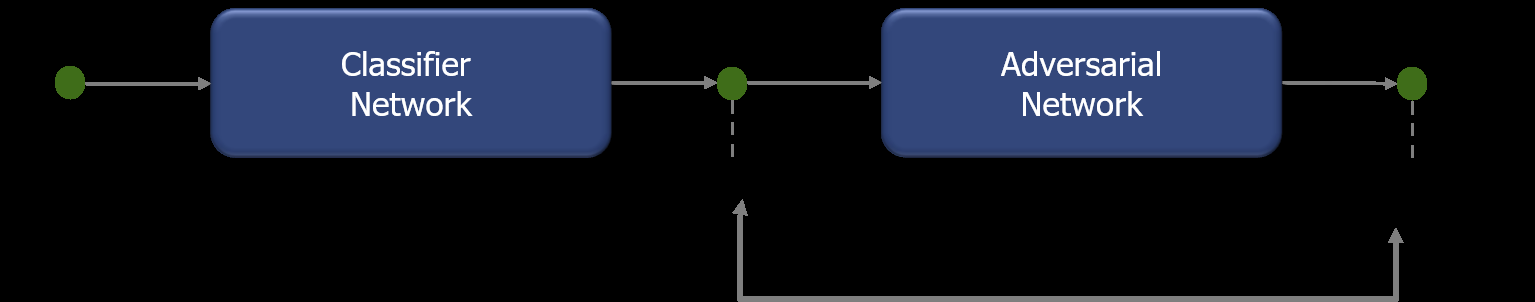

In [20]:
img = cv2.imread('images/adversarial_debiasing_training.png')
cv2_imshow(img)

As shown in the above Fig, at first the Classifier model will generate predictions $\hat{y}$ base on the input ${X}$. The Adversararial model will then try to predict the sensitive attribute values $\hat{Z}$ from the predicted $\hat{y}$ of the classifier. Finally, the objectives that both the models try to optimize are based on the prediction losses of the target and sensitive attributes. These are denoted by $Loss_{clf}$ and $Loss_{adv}$ in the figure.

The Classifier and Adversarial networks are trained turn by turn (in the form of a zero-sum game, where one agent's gain is another agent's loss) with the objective of minimizing the loss of both the networks.

For the classifier, the objective is two-fold: make the best possible predictions while ensuring that sensitive attributes cannot be derived from them. This is captured by the following objective function

$$ \min[Loss_{clf}-\lambda Loss_{adv}]$$

So, it learns to minimize its own prediction losses while maximizing that of the adversarial (due to $\lambda$ being positive and minimizing a negated loss is the same as maximizing it). Note that increasing the size of $\lambda$ steers the classifier network towards fairer predictions while sacrificing prediction accuracy.


The adversary learns on the full data set and the classifier is given only the single batch, giving the adversary a slight edge in learning. The loss function for the classifier is changed to its original loss plus the weighted negative adversarial loss.

In [21]:
clfloss = loss - adv_loss

In short:
* Train the classifier on full data set for few epochs.

Train the adversarial and classifier networks simultaneously:
* Train the adversarial for a single epoch while keeping the classifier fixed.
* Train the classifier on a single sampled mini batch while keeping the adversarial fixed

In [22]:
max_iter = 449
for epoch in range(200):
    clf.need_grad = False
    for i in range(max_iter):
        n_feature.d, n_label.d, n_senstive.d = trainloader.next()
        adv_solver.zero_grad()
        adv_loss.forward()
        adv_loss.backward(clear_buffer=True)
        adv_solver.update()

    for i in range(max_iter):
        n_feature.d, n_label.d, n_senstive.d = trainloader.next()
        pass
    clf.need_grad = True
    loss.forward(clear_no_need_grad=True)
    clf_solver.zero_grad()
    clfloss.forward(clear_no_need_grad=True)
    clfloss.backward(clear_buffer=True)
    clf_solver.update()

### Model Fairness: Adversarial network

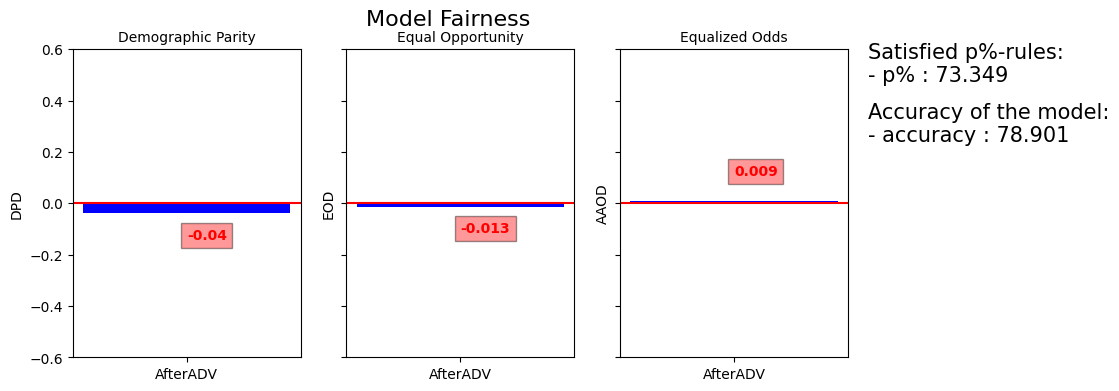

In [23]:
test_feature.d, test_label.d,test_senstive.d = testloader.next()
v_clf_out.forward(clear_buffer=True)
y_pre_clf = v_clf_out.d.ravel()
preds = np.where(y_pre_clf > 0.5, 1, 0)
DPD,EOD,AAOD = get_fairness(y_test, Z_test['race'] == 1, preds)
clf_accuracy = metrics.accuracy_score(y_test, preds) * 100
race_p_rule = get_p_rule(y_pre_clf, Z_test['race'])
plot_fairness_multi(DPD,EOD,AAOD,race_p_rule,clf_accuracy,"AfterADV")

The plots above show how the model fairness improved (Demographic parity, Equal opportunity & Equalized odds are almost zero and the p% rule gives us the value of ~77, almost twice as likely to be fair than that of the previous approach) after adversarial debiasing training.

However, the accuracy of classification dropped around ~5% (reduction in accuracy can be controlled). We end up with a classifier that makes fair predictions when it comes to race as a sensitive attribute. Decent outcome!

## 5. Summary

In this tutorial,  we have shown how to reduce the bias and force our model into making fair predictions by `Adversarial Debiasing` procedure (in-processing technique). And yes, making fair predictions comes at a cost: it will reduce the performance of our model (hopefully, only by a little). However, in many cases, this will be a relatively small price to pay.

## References

1. [Classification with Fairness Constraints: A Meta-Algorithm with Provable Guarantees](https://arxiv.org/abs/1806.06055)
2. [Prejudice Remover Regularizer](https://link.springer.com/content/pdf/10.1007%2F978-3-642-33486-3_3.pdf)
3. [Mitigating Unwanted Biases with Adversarial Learning](https://arxiv.org/pdf/1801.07593.pdf)
4. [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
5. [Adult — UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/Adult)
6. [Fairness Constraints: Mechanisms for Fair Classification](https://arxiv.org/pdf/1507.05259.pdf)